<a href="https://colab.research.google.com/github/bsttiv/tipos_espectrales/blob/main/Tipos_Espectrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerías a utilizar**

In [1]:
# Para leer la base de datos guardada en Google Drive
from google.colab import drive

In [2]:
# Procesamiento y limpieza de datos
import pandas as pd
import numpy as np

In [3]:
# Creación de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Medición de tiempos
import time

In [5]:
# Separación de sets de entrenamiento y testeo
from sklearn.model_selection import train_test_split

# Preparación de Sets de datos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Para tunear los parámetros del RandomForest y GradientBoosting
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# K-Vecinos más cercanos
from sklearn.neighbors import KNeighborsClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Matriz de confusion
from sklearn.metrics import confusion_matrix
# Reporte de clasificación
from sklearn.metrics import classification_report
# Cross-Validation
from sklearn.model_selection import cross_val_score
# Métrica precision a utilizar para Cross Validation
from sklearn.metrics import f1_score, make_scorer

# Red neuronal
import tensorflow as tf
from tensorflow import keras

# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# **Funciones/variables de utilidad**

In [6]:
# Funciones que se usan en el parámetro converters del método read_csv
# Su objetivo es filtrar los datos y eliminar aquellos que no estén en el formato correcto

def texto_a_float(texto):
  try:
    return np.float64(texto.strip())
  except Exception:
    return np.nan

def texto_mayuscula_primera_letra(texto):
  try:
    return texto.strip().upper()[0]
  except Exception:
    return "NaN"

In [7]:
# Tipos espectrales en los q estamos interesados
tipos_espectrales = ["O", "B", "A", "F", "G", "K", "M"]

In [8]:
# Función de scoring que se utilizará en Cross Validation
scoring = make_scorer(f1_score, average="weighted", labels=tipos_espectrales, zero_division=0, pos_label=None)

# **Limpieza de los datos**

In [9]:
# Se monta el drive para cargar los datos
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Ruta de la base de datos
ruta = "drive/MyDrive/Modulo/Tipos_Espectrales/hip_main.dat"
# Nombres de las columnas (según la especificación de https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html)
names = ["H"+str(i) for i in range(0, 78)]
# Se lee la base de datos con los parámetros adecuados
df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)
# Se eliminan aquellas filas cuyo tipo espectral no coincida con los buscados (O, B, A, F, G, K, M)
df = df[df["H76"].isin(tipos_espectrales)]
# Se borran las columnas que no se usarán
labels = ["H"+str(i) for i in range(0, 78) if i not in [76, 32, 37, 40]]
df.drop(labels=labels, inplace=True, axis=1)
# Se eliminan todas las filas que posiblemente no tengan valores definidos
df.dropna(axis=0, inplace=True)
# Se muestra el DataFrame
df

<ipython-input-10-3a6df1d0f274>:6: DtypeWarning: Columns (5,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, sep="|", converters={"H76": texto_mayuscula_primera_letra, "H32": texto_a_float, "H37": texto_a_float, "H40": texto_a_float}, names=names, keep_default_na=False)


,H32,H37,H40,H76
0,9.643,0.482,0.55,F
1,10.519,0.999,1.04,K
2,6.576,-0.019,0.00,B
3,8.471,0.370,0.43,F
4,9.693,0.902,0.90,G
...,...,...,...,...
118213,9.107,1.595,1.61,K
118214,9.019,0.639,0.70,G
118215,8.868,0.999,0.98,K
118216,10.077,0.698,0.75,G


In [11]:
# Se extraen las filas de cada tipo espectral para posteriormente usar el método describe
# Y visualizar las estadísticas de los datos

df_tipo_o = df[df["H76"] == "O"]
df_tipo_b = df[df["H76"] == "B"]
df_tipo_a = df[df["H76"] == "A"]
df_tipo_f = df[df["H76"] == "F"]
df_tipo_g = df[df["H76"] == "G"]
df_tipo_k = df[df["H76"] == "K"]
df_tipo_m = df[df["H76"] == "M"]

In [12]:
df_tipo_o.describe()

,H32,H37,H40
count,255.000000,255.000000,255.000000
mean,8.008573,0.222824,0.258627
std,1.822831,0.302070,0.317725
min,1.566000,-0.335000,-0.370000
25%,7.060000,0.009000,0.030000
50%,8.176000,0.169000,0.180000
75%,9.246500,0.405000,0.480000
max,11.624000,1.408000,1.390000


In [13]:
df_tipo_b.describe()

,H32,H37,H40
count,10341.000000,10341.000000,10341.000000
mean,7.843250,0.046298,0.067571
std,1.489189,0.187834,0.199207
min,0.312000,-0.400000,-0.420000
25%,7.008000,-0.066000,-0.040000
50%,7.986000,-0.004000,0.020000
75%,8.846000,0.101000,0.110000
max,12.843000,1.910000,2.480000


In [14]:
df_tipo_a.describe()

,H32,H37,H40
count,18550.000000,18550.000000,18550.000000
mean,8.230618,0.179759,0.205729
std,1.209015,0.147032,0.158022
min,1.248000,-0.400000,-0.290000
25%,7.582000,0.075000,0.090000
50%,8.350000,0.170000,0.190000
75%,9.025000,0.267000,0.300000
max,11.934000,1.745000,2.160000


In [15]:
df_tipo_f.describe()

,H32,H37,H40
count,25306.000000,25306.000000,25306.000000
mean,9.071121,0.476358,0.542513
std,1.158848,0.117243,0.116609
min,-0.417000,-0.400000,-0.160000
25%,8.407000,0.408000,0.480000
50%,9.132000,0.472000,0.540000
75%,9.845000,0.530000,0.600000
max,12.839000,2.180000,2.780000


In [16]:
df_tipo_g.describe()

,H32,H37,H40
count,22409.000000,22409.000000,22409.000000
mean,9.536064,0.787254,0.817905
std,1.075112,0.206393,0.171363
min,3.418000,-0.400000,-0.100000
25%,8.977000,0.624000,0.690000
50%,9.656000,0.740000,0.790000
75%,10.240000,0.955000,0.950000
max,12.869000,2.215000,2.960000


In [17]:
df_tipo_k.describe()

,H32,H37,H40
count,31378.000000,31378.000000,31378.000000
mean,9.710005,1.202528,1.193795
std,1.124681,0.233951,0.247679
min,1.629000,-0.400000,-0.060000
25%,9.081000,1.040000,1.020000
50%,9.850500,1.165000,1.130000
75%,10.456000,1.365000,1.350000
max,13.130000,2.867000,3.510000


In [18]:
df_tipo_m.describe()

,H32,H37,H40
count,4148.000000,4148.000000,4148.000000
mean,10.171799,1.561587,2.269812
std,1.352534,0.209219,0.684430
min,2.849000,0.000000,0.010000
25%,9.362000,1.483000,1.840000
50%,10.350500,1.589000,2.150000
75%,11.130500,1.659000,2.560000
max,13.247000,3.315000,5.750000


Los campos a utilizar serán "H32" (que corresponde a magnitud); "H37", "H40" (índices de color); y "H76" (tipo espectral)

https://heasarc.gsfc.nasa.gov/w3browse/all/hipparcos.html

# **Visualización de los datos**

Text(0.5, 1.0, 'Número de estrellas por tipo espectral')

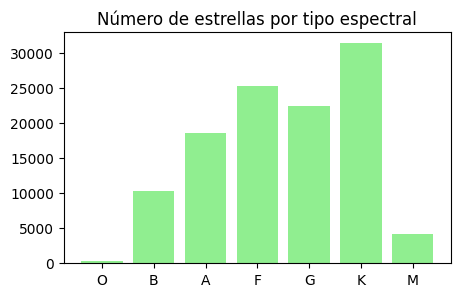

In [19]:
_, ax = plt.subplots(figsize=(5,3))

# Cantidad de estrellas por cada tipo espectral
n_tipos = [len(df_tipo_o), len(df_tipo_b), len(df_tipo_a), len(df_tipo_f), len(df_tipo_g), len(df_tipo_k), len(df_tipo_m)]

# Se grafica la cantidad de estrellas vs tipo espectral
ax.bar(tipos_espectrales, n_tipos, color='lightgreen')

ax.set_title("Número de estrellas por tipo espectral")


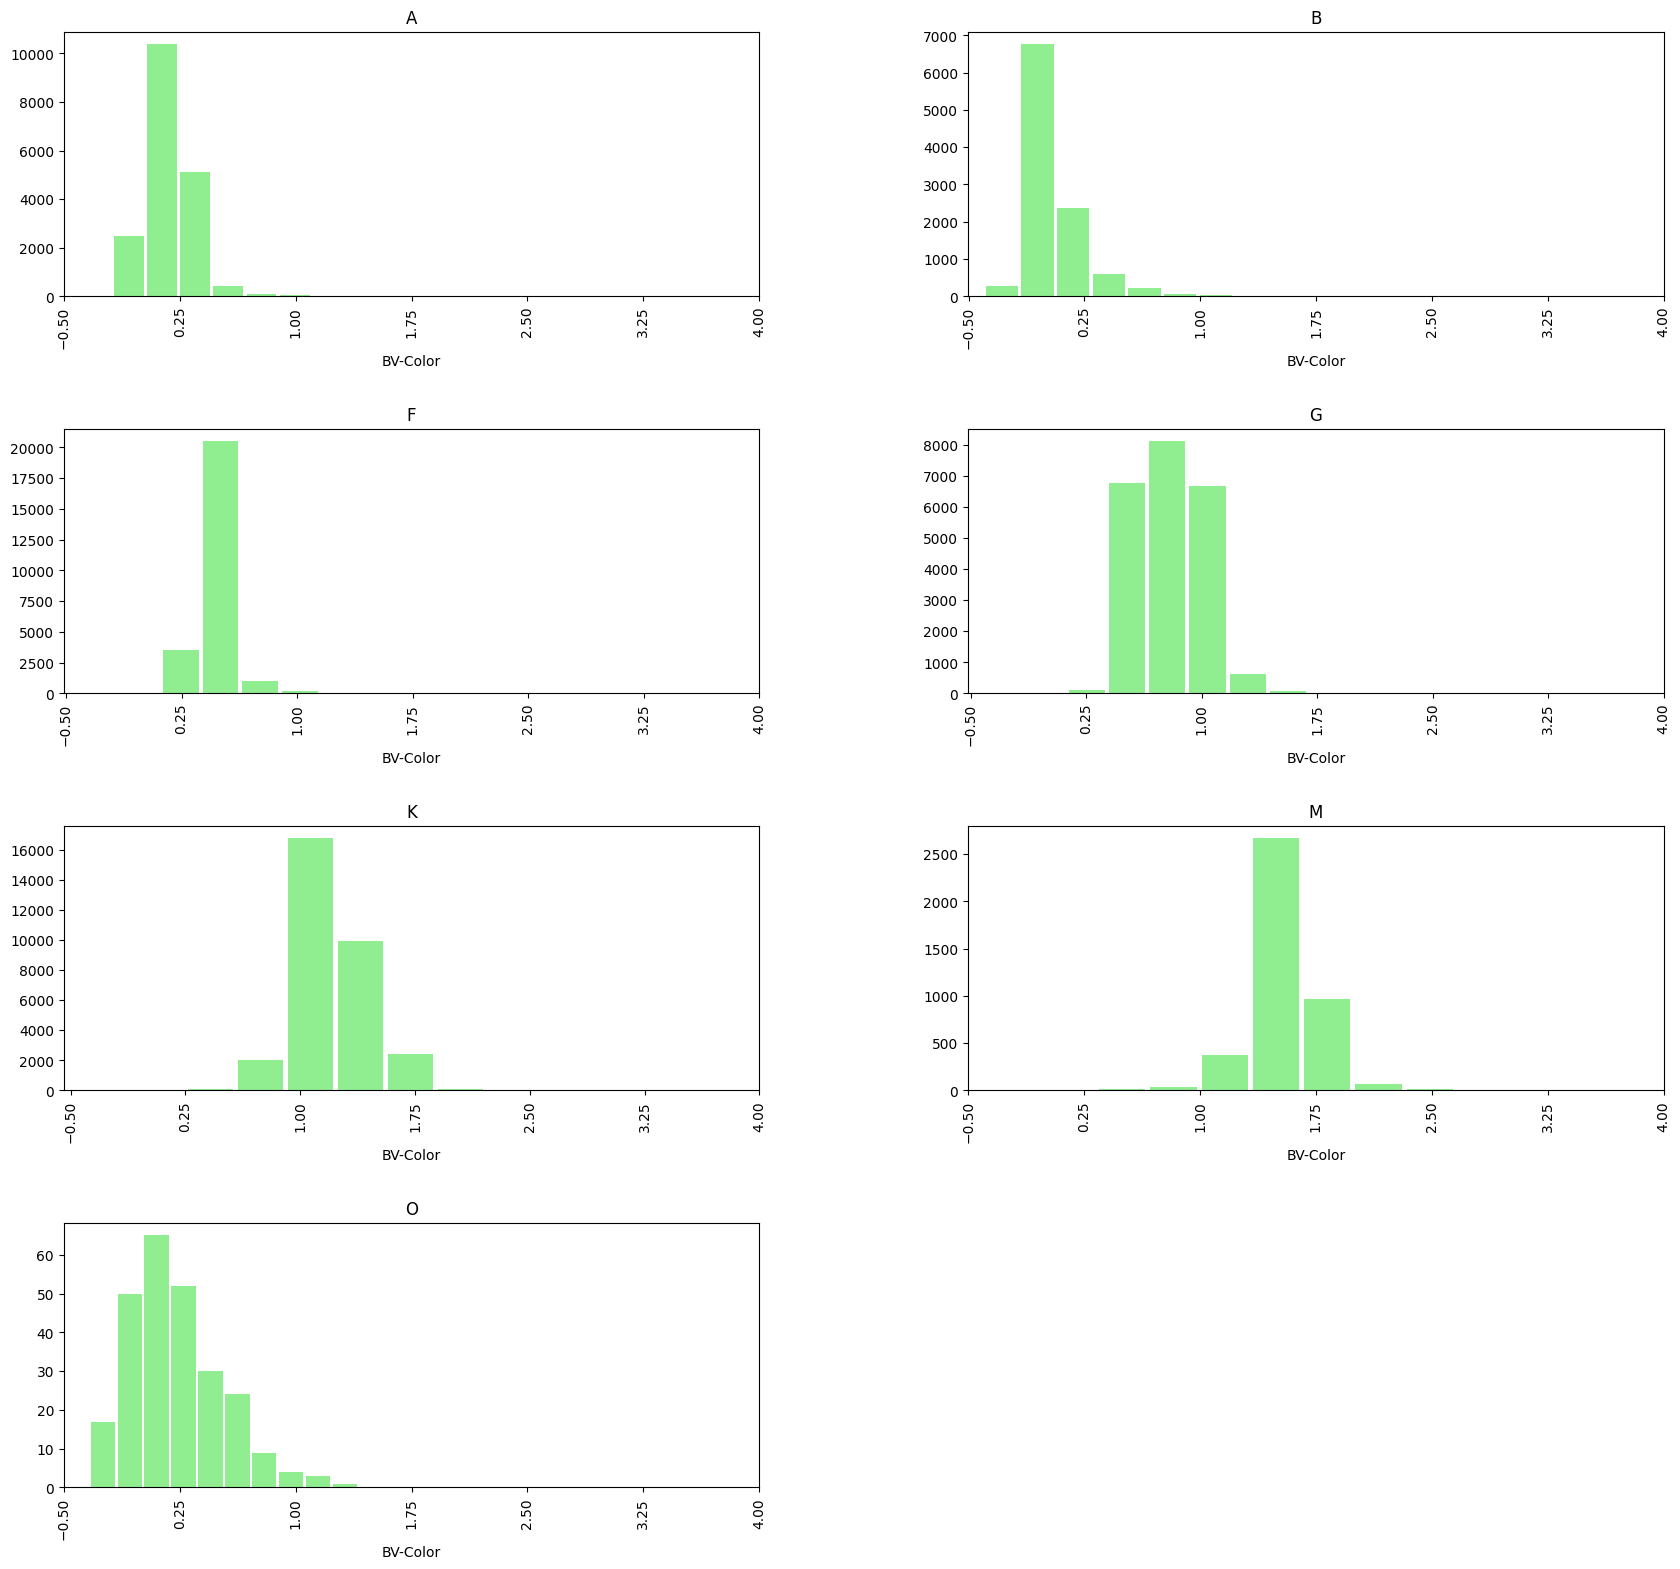

In [20]:
# Histograma BV-Color
ax = df.hist(column="H37", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BV-Color")
    x.set_xticks(np.linspace(-0.5, 4, 7))

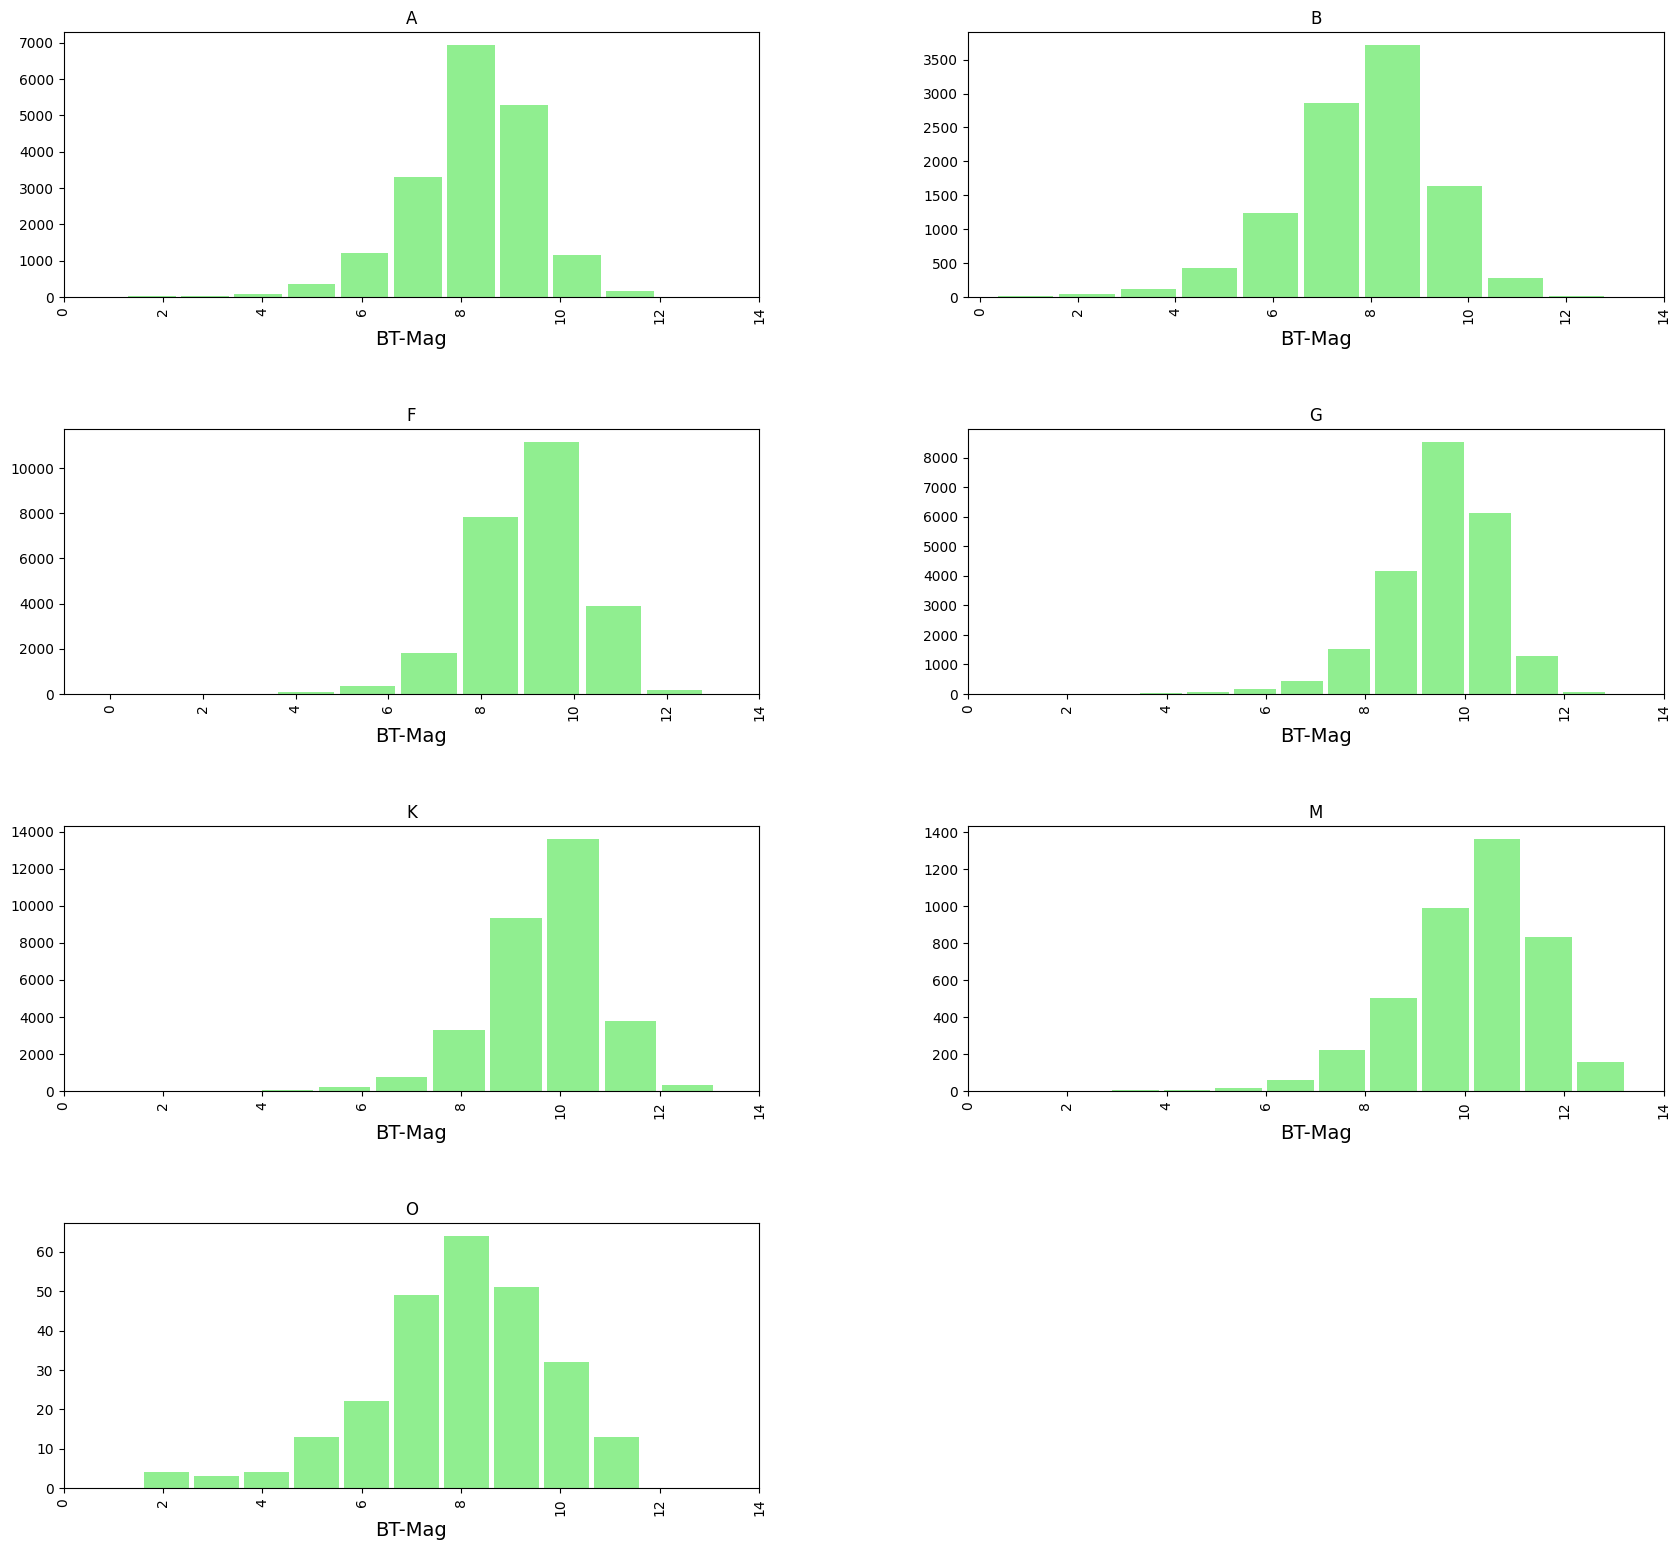

In [21]:
# Histograma BT-Mag
ax = df.hist(column="H32", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("BT-Mag", size=14)
    x.set_xticks(range(0, 15, 2))

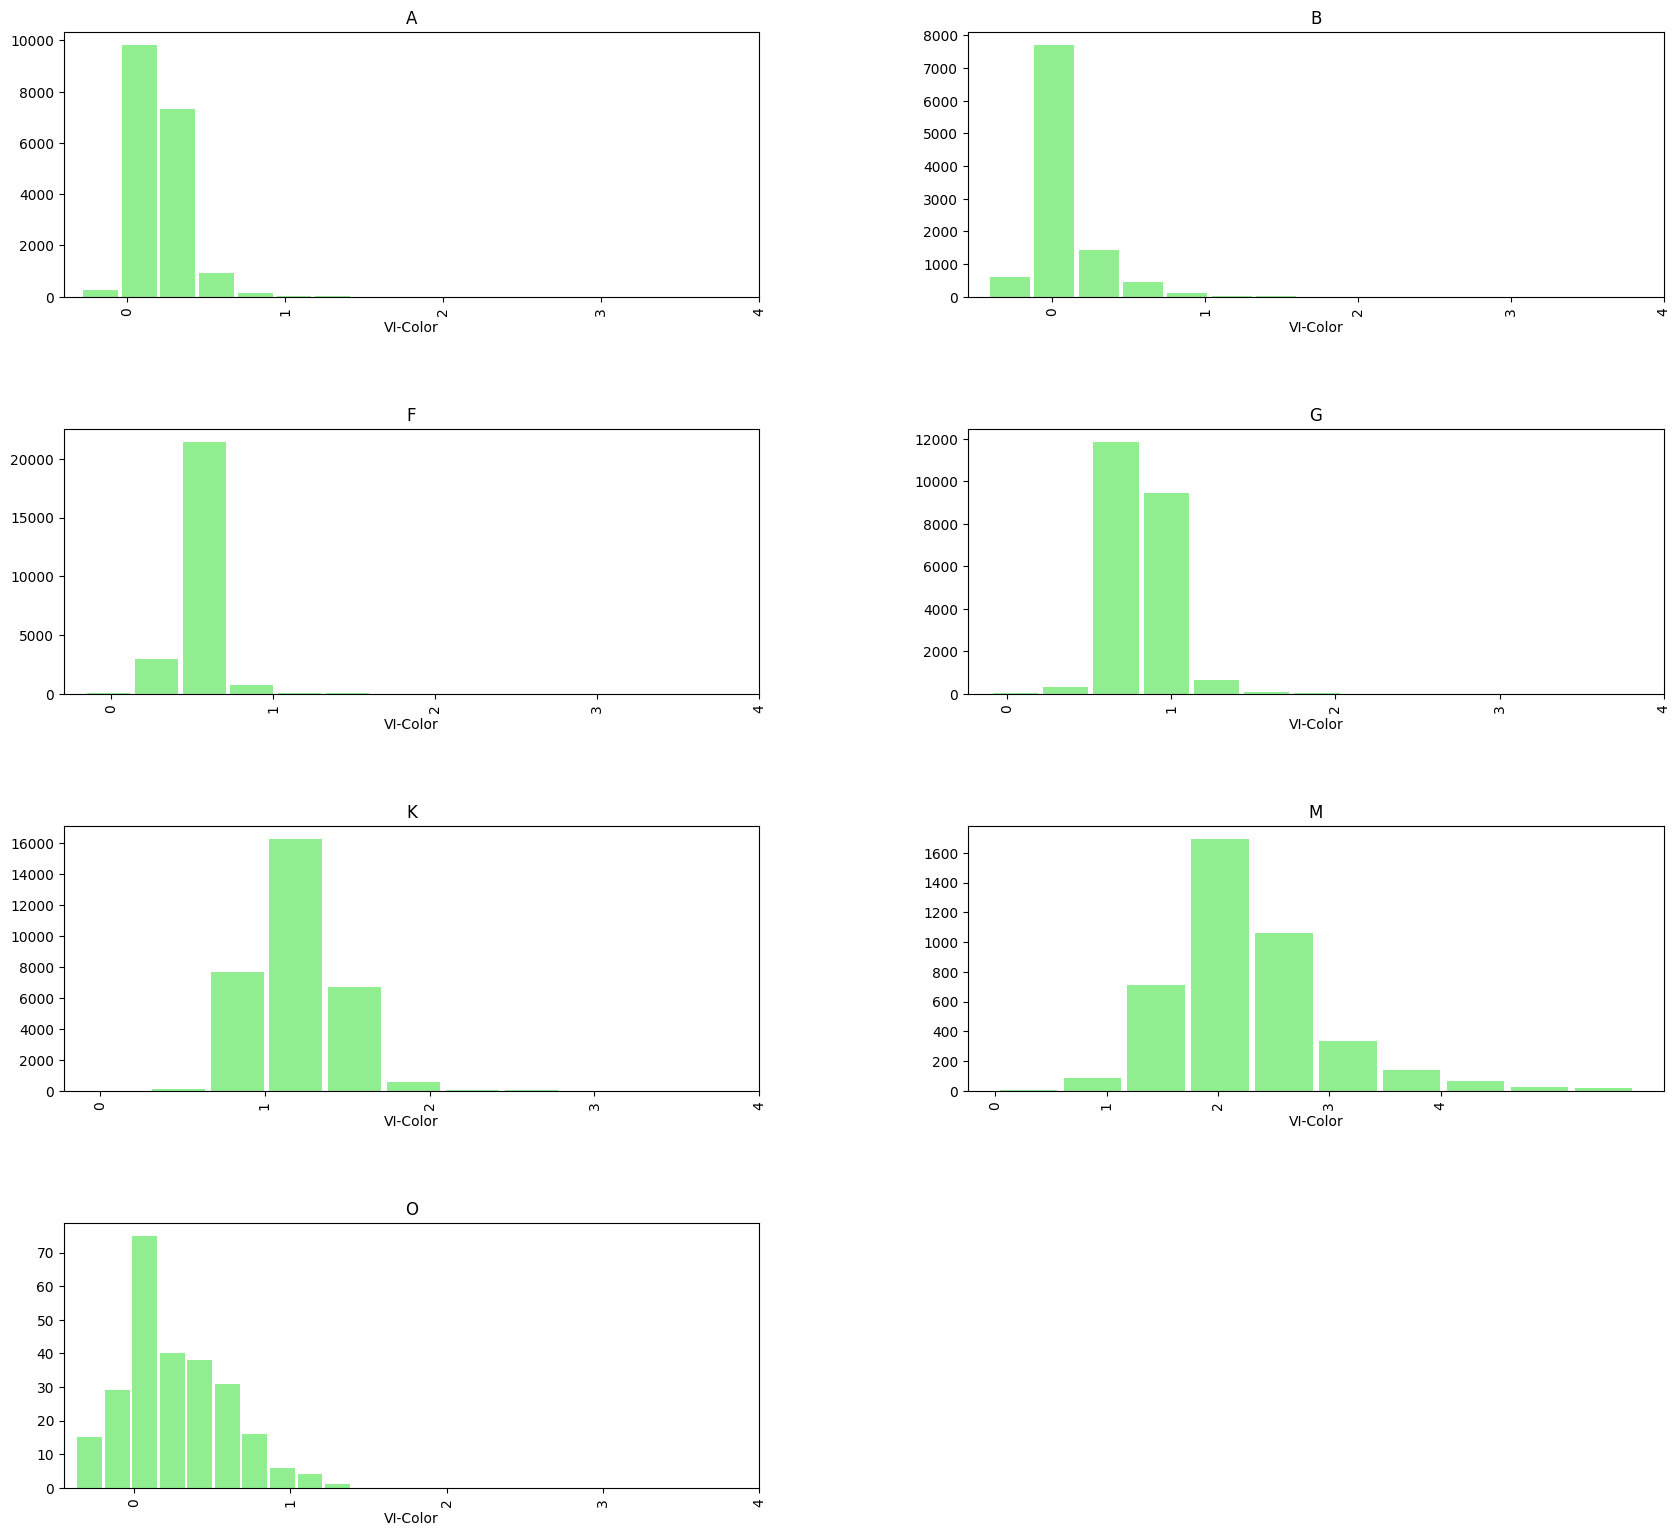

In [22]:
# Histograma VI-Color
ax = df.hist(column="H40", by=df["H76"], figsize=(20,30), layout=(6,2), color='lightgreen', rwidth=0.9)

for row in ax:
  for x in row:
    x.set_xlabel("VI-Color")
    x.set_xticks(np.linspace(0, 4, 5))

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seabo

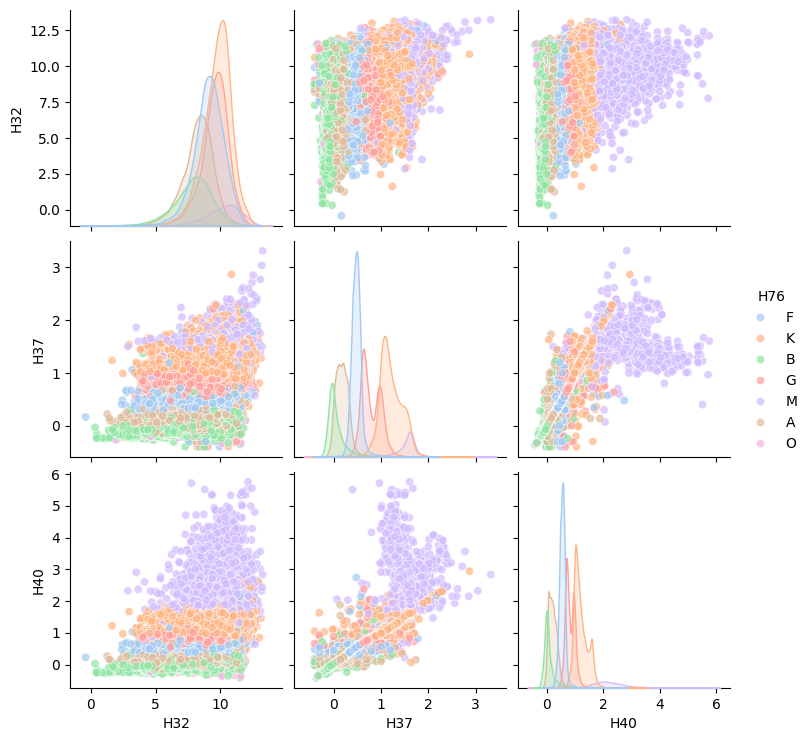

In [23]:
# Pairplot para ver correlación entre las features elegidas y el tipo espectral
sns.pairplot(df, hue = 'H76', diag_kind = 'kde', palette= sns.color_palette("pastel"), plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(fill=True))

# **Preparación de los datos para entrenamiento/Testing**

In [24]:
# Se separa el dataframe en una proporción 80% entrenamiento y 20% testeo
train_df, test_df = train_test_split(df, test_size=.20, random_state=2201)

In [25]:
# Se extraen las etiquetas (labels)
train_labels = train_df.pop("H76")
test_labels = test_df.pop("H76")

In [26]:
# Se extraen las características (features)
train_features = np.array(train_df)
test_features = np.array(test_df)

# **Modelo: Random Forest**

https://youtube.com/watch?v=AYICIq5jnhU&si=3e1M0dp2M4Jl7j5Y

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [27]:
# Tuning de parametros basado en: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

split = train_features.size/100
params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
}

# Se crea el RandomForest con los parametros específicados
random_forest = RandomForestClassifier(**params)

# Se crea un cross validator del tipo Repeated Stratified K-Fold (útil en clasificación multiclase)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=3453)

# Se crea el GridSearch para encontrar los mejores parámetros
grid_search = GridSearchCV(random_forest, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=-1, cv=cv, scoring=scoring)

In [28]:
start = time.time()
# Se entrena el algoritmo
grid_search.fit(train_features, train_labels.values.ravel())
end = time.time()

In [29]:
print(f"Tiempo usado en entrenar: {end-start} [segundos]")

Tiempo usado en entrenar: 562.6898682117462 [segundos]


In [30]:
print("F1-Score después del tuneo de parámetros: ", grid_search.score(test_features, test_labels))

F1-Score después del tuneo de parámetros:  0.7621140295545887


In [31]:
# Se hacen las predicciones usando los datos de testeo
predicted = grid_search.predict(test_features)

Text(0.5, 1.0, 'Matriz de confusión de Random Forest')

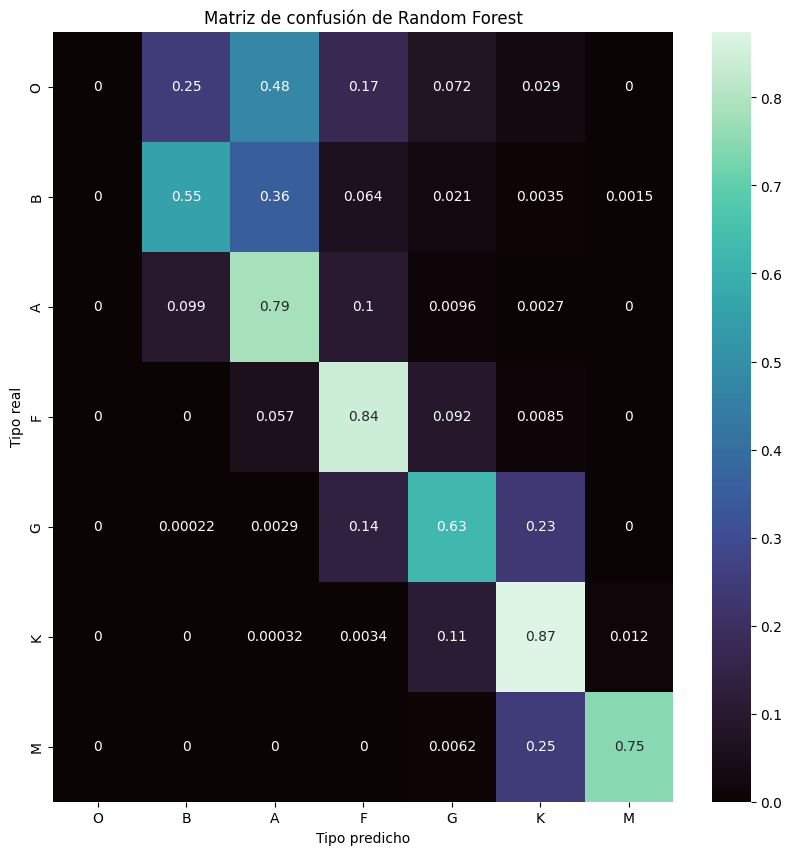

In [32]:
# Se crea la matriz de confusión usando el método confusion_matrix, específicando a que corresponde cada fila y columna
cm = pd.DataFrame(confusion_matrix(test_labels, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Random Forest")

In [33]:
# Reporte de clasificación
print(classification_report(test_labels, predicted, zero_division=0))

              precision    recall  f1-score   support

           A       0.74      0.79      0.76      3737
           B       0.74      0.55      0.63      2013
           F       0.79      0.84      0.81      5081
           G       0.70      0.63      0.66      4532
           K       0.81      0.87      0.84      6244
           M       0.88      0.75      0.81       802
           O       0.00      0.00      0.00        69

    accuracy                           0.77     22478
   macro avg       0.66      0.63      0.65     22478
weighted avg       0.76      0.77      0.76     22478



# **Modelo: Gradient Boosting**

https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm

In [34]:
# Tuning de parametros basado en: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params = {  'min_samples_split' : int(split),
            'min_samples_leaf' : int(split/10),
            'max_depth' : 6,
            'max_features' : 'sqrt',
            'subsample' : 0.8
}

# Se crea el GradientBoosting con los parametros específicados
gradient_boosting = GradientBoostingClassifier(**params)

# Se crea el GridSearch para encontrar los mejores parámetros
grid_search = GridSearchCV(gradient_boosting, param_grid = { 'n_estimators': range(15, 81, 10) }, n_jobs=-1, cv=5, scoring=scoring)

In [35]:
start = time.time()
# Se entrena el algoritmo
grid_search.fit(train_features, train_labels.values.ravel())
end = time.time()

In [36]:
print(f"Tiempo usado en entrenar: {end-start} [segundos]")

Tiempo usado en entrenar: 498.6569769382477 [segundos]


In [37]:
print("F1-Score despúes del tuneo de parámetros: ", grid_search.score(test_features, test_labels))

F1-Score despúes del tuneo de parámetros:  0.7693623348576915


In [38]:
# Se hacen las predicciones usando los datos de testeo
predicted = grid_search.predict(test_features)

Text(0.5, 1.0, 'Matriz de confusión de Gradient Boosting')

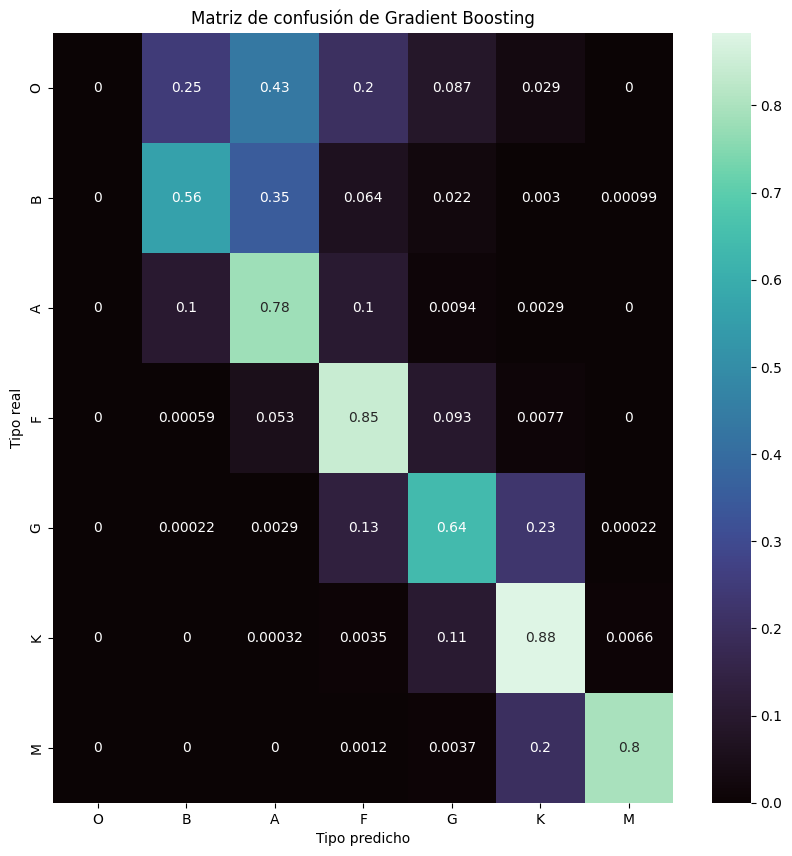

In [39]:
# Se crea la matriz de confusión usando el método confusion_matrix, específicando a que corresponde cada fila y columna
cm = pd.DataFrame(confusion_matrix(test_labels, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de Gradient Boosting")

In [40]:
# Reporte de clasificación
print(classification_report(test_labels, predicted, zero_division=0))

              precision    recall  f1-score   support

           A       0.74      0.78      0.76      3737
           B       0.74      0.56      0.64      2013
           F       0.79      0.85      0.82      5081
           G       0.70      0.64      0.67      4532
           K       0.82      0.88      0.85      6244
           M       0.94      0.80      0.86       802
           O       0.00      0.00      0.00        69

    accuracy                           0.77     22478
   macro avg       0.67      0.64      0.66     22478
weighted avg       0.77      0.77      0.77     22478



# **Modelo: K-Vecinos más cercanos**

In [41]:
# Se crea una lista de valores a probar para el parámetro n_neighbors (número de vecinos en el algortimo)
k_values = [i for i in range (1,50)]
# Lista en donde se guardarán los scores para cada valor de n_neighbors
scores = []

# Se procede a realizar validación cruzada para cada valor de k usado f1-score como métrica
for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(classifier, train_features, train_labels.values.ravel(), cv=5, scoring=scoring)
    scores.append(np.mean(score))

Text(0, 0.5, 'F1-Score')

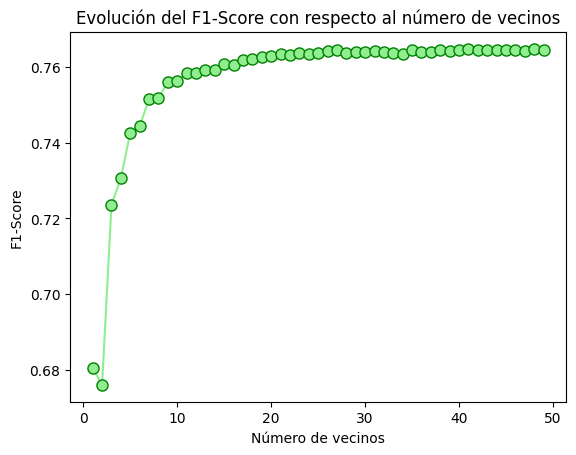

In [42]:
# Se grafica el F1-Score con respecto al número de vecinos
plt.plot(k_values, scores, marker = 'o', color='lightgreen', ms=8, mec='g')
plt.title("Evolución del F1-Score con respecto al número de vecinos")
plt.xlabel("Número de vecinos")
plt.ylabel("F1-Score")

In [43]:
# Se muestra el valor de k que obtuvo mejor score
best_k = k_values[np.argmax(scores)]
print(best_k)

41


In [44]:
# Se entrena el algoritmo KNN usando el k encontrado en el bloque de código anterior
knn = KNeighborsClassifier(n_neighbors=best_k)
start = time.time()
knn.fit(train_features, train_labels.values.ravel())
end = time.time()

In [45]:
print(f"Tiempo usado en entrenar: {end-start} [segundos]")

Tiempo usado en entrenar: 0.1419377326965332 [segundos]


In [46]:
# Se hacen las predicciones usando los datos de testeo
predicted = knn.predict(test_features)

In [47]:
# Se calcula el f1-score
score = f1_score(test_labels, predicted, average="weighted")
print(f"F1-Score: {score}")

F1-Score: 0.7631331407722288


Text(0.5, 1.0, 'Matriz de confusión de K-Vecinos más cercanos')

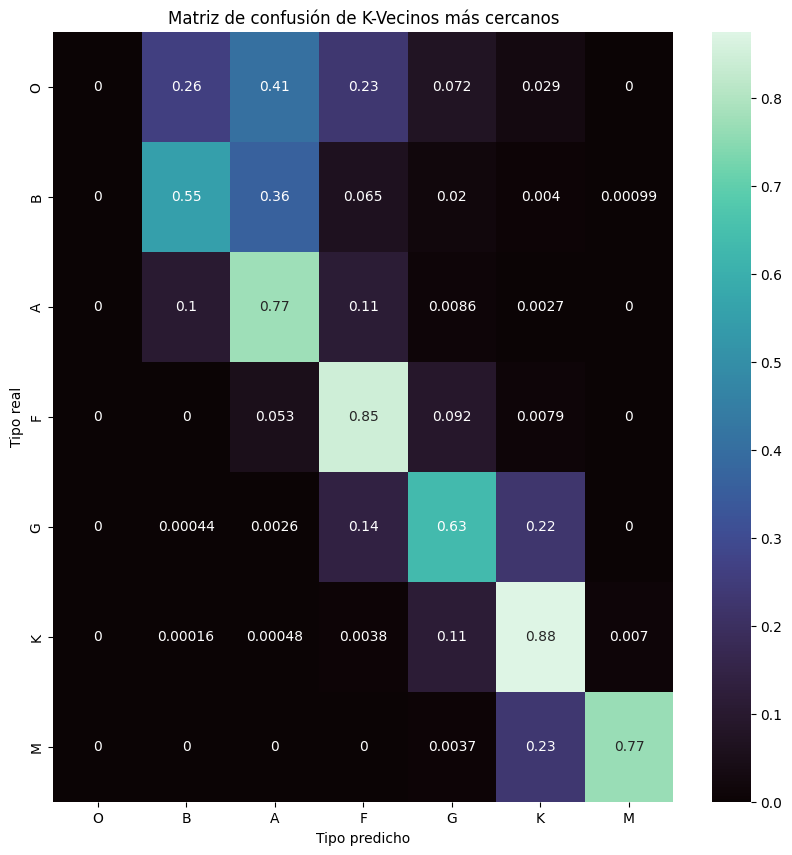

In [48]:
# Se crea la matriz de confusión usando el método confusion_matrix, específicando a que corresponde cada fila y columna
cm = pd.DataFrame(confusion_matrix(test_labels, predicted, normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de K-Vecinos más cercanos")

In [49]:
# Reporte de clasificación
print(classification_report(test_labels, predicted, zero_division=0))

              precision    recall  f1-score   support

           A       0.74      0.77      0.75      3737
           B       0.73      0.55      0.63      2013
           F       0.78      0.85      0.81      5081
           G       0.70      0.63      0.66      4532
           K       0.81      0.88      0.84      6244
           M       0.93      0.77      0.84       802
           O       0.00      0.00      0.00        69

    accuracy                           0.77     22478
   macro avg       0.67      0.64      0.65     22478
weighted avg       0.76      0.77      0.76     22478



# **Modelo: Red Neuronal**

Referencia: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [50]:
# Este código sirve para "transformar" los labels (tipos espectrales tipo str) en números
encoder = LabelEncoder()
encoder.fit(tipos_espectrales)
train_labels_enc = encoder.transform(train_labels)
test_labels_enc = encoder.transform(test_labels)

In [51]:
# One-hot encoding para los labels
train_labels_enc = keras.utils.to_categorical(train_labels_enc, num_classes=7)
test_labels_enc = keras.utils.to_categorical(test_labels_enc, num_classes=7)

In [52]:
# "Estandarización" del set de características
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


In [53]:
# Métricas a utilizar para evaluar el rendimiento
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.F1Score(name='f1_score', average='weighted'),
]

# Se crea el modelo con 3 capas densas, entregando la última los resultados
# con una función de activación 'softmax'
model = keras.Sequential([
    keras.layers.Input((train_features.shape[-1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

In [54]:
# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_focal_crossentropy',
    metrics=METRICS
)

In [55]:
# Se muestra la estructura del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 839 (3.28 KB)

 Trainable params: 839 (3.28 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Entrenamiento del modelo usando 80 épocas y un tamaño de batch de 2048
result = model.fit(train_features, train_labels_enc, batch_size=2048, epochs=80)

Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9084 - f1_score: 0.6943 - fn: 21636.3555 - fp: 8581.9336 - loss: 0.0829 - precision: 0.7475 - recall: 0.5417 - tn: 273714.8750 - tp: 25413.1113
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - f1_score: 0.6950 - fn: 21637.1992 - fp: 8568.7109 - loss: 0.0834 - precision: 0.7472 - recall: 0.5395 - tn: 273728.0938 - tp: 25412.2676
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9075 - f1_score: 0.6951 - fn: 21911.1328 - fp: 8441.0889 - loss: 0.0843 - precision: 0.7472 - recall: 0.5330 - tn: 273855.7188 - tp: 25138.3340
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9086 - f1_score: 0.6958 - fn: 21467.4219 - fp: 8622.9775 - loss: 0.0827 - precision: 0.7483 - recall: 0.5429 - tn: 273673.8125 - tp: 25582.0449
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - f1_score: 0.6981 - fn: 21603.0898 - fp: 8448.7109 - loss: 0.0834 - precision: 0.7501 - recall: 0.

In [65]:
# Nombres de las métricas a mostrar
metric_names = ['loss']
metric_names.extend([m.name for m in METRICS])

In [66]:
# Evaluación del modelo en el set de testeo
results = model.evaluate(x=test_features, y=test_labels_enc)
# Se muestran los valores de cada métrica
for (metric_name, value) in zip(metric_names, results):
  print(f"{metric_name}: {value}")

703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9099 - f1_score: 0.6643 - fn: 4924.5454 - fp: 2163.0398 - loss: 0.0770 - precision: 0.7444 - recall: 0.5622 - tn: 65516.3789 - tp: 6355.3579
loss: 0.07612210512161255
tp: 12685.0
fp: 4270.0
tn: 130598.0
fn: 9793.0
precision: 0.7481569051742554
accuracy: 0.91062331199646
recall: 0.5643295645713806
f1_score: 0.6661369800567627


In [69]:
# Valores del f1_score y función de costos a medida que progresan las épocas
f1_score_ev_1 = result.history['f1_score']
loss_ev_1 = result.history['loss']
# Array que contiene las épocas
epochs = np.arange(80)

Text(0, 0.5, 'F1-Score')

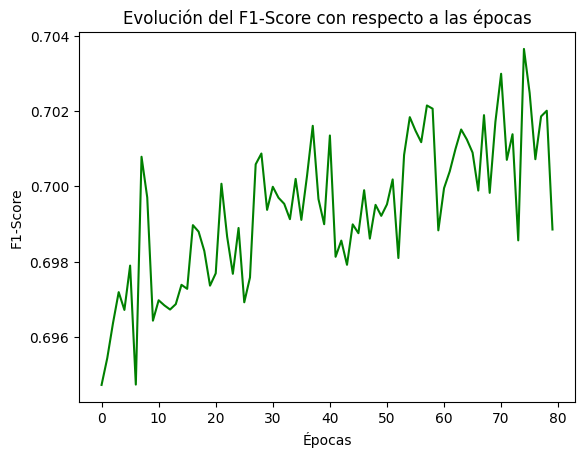

In [70]:
# Se grafica el f1_score con respecto a las épocas
plt.plot(epochs, f1_score_ev_1, color='green')
plt.title("Evolución del F1-Score con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("F1-Score")

Text(0, 0.5, 'Función de costos')

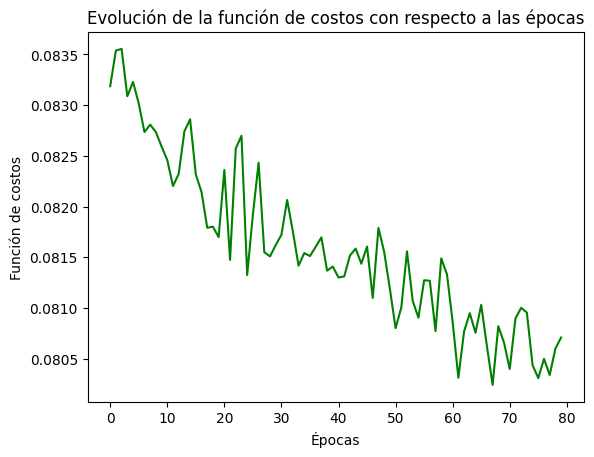

In [71]:
# Se grafica la función de costos con respecto a las épocas
plt.plot(epochs,loss_ev_1, color="green")
plt.title("Evolución de la función de costos con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Función de costos")

In [72]:
# Se hacen las predicciones usando los datos de testeo
pred = model.predict(test_features)
# Código para "retraer" el One-Hot encoding y volver al LabelEncoding
pred = np.argmax(pred, axis = 1)
test_labels = np.argmax(test_labels_enc, axis=1)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Text(0.5, 1.0, 'Matriz de confusión de la red neuronal')

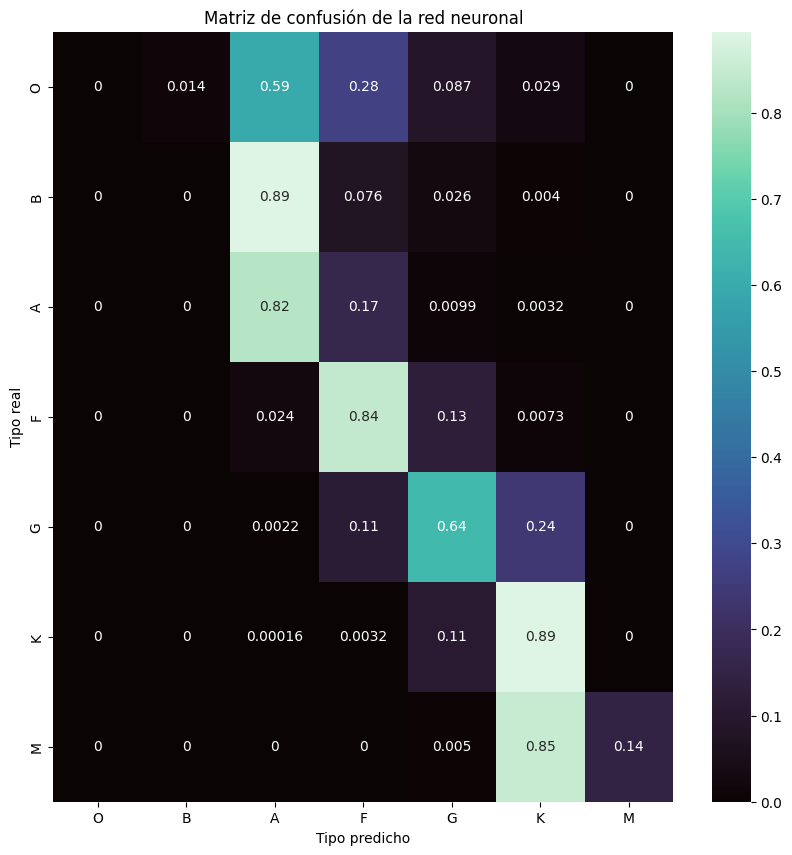

In [73]:
# Se crea la matriz de confusión usando el método confusion_matrix, específicando a que corresponde cada fila y columna
_, ax = plt.subplots(figsize=(10,10))
cm = pd.DataFrame(confusion_matrix(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))

ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de la red neuronal")

In [74]:
# Reporte de clasificación
print(classification_report(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), zero_division=0))

              precision    recall  f1-score   support

           A       0.61      0.82      0.70      3737
           B       0.00      0.00      0.00      2013
           F       0.76      0.84      0.80      5081
           G       0.68      0.64      0.66      4532
           K       0.75      0.89      0.82      6244
           M       1.00      0.14      0.25       802
           O       0.00      0.00      0.00        69

    accuracy                           0.71     22478
   macro avg       0.54      0.48      0.46     22478
weighted avg       0.66      0.71      0.67     22478



In [75]:
# Se limpia la memoria de la sesión para proseguir con la segunda prueba de entrenamiento
tf.keras.backend.clear_session(
    free_memory=True
)

In [76]:
# Número de estrellas por clase
num_values = train_labels.value_counts()

In [77]:
# Se calculan los pesos de cada clase usando la formula: total_datos/(datos_clase * número de clases)
class_weights = dict(enumerate([ len(train_labels) / num_values[c] / 7 for c in encoder.classes_ ]))
class_weights

{0: 0.8670858608751001,
 1: 1.5422842047481817,
 2: 0.6350626876214021,
 3: 0.718473057959549,
 4: 0.5110266116472848,
 5: 3.8386559644778413,
 6: 69.05453149001536}

In [78]:
# Early Stopping para evitar el Overfitting del algoritmo
# patience indica cuantas épocas sin mejorías en los resultados se toleran
# min_delta indica el valor a partir del cual se considera que hubo una mejoría en los resultados
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=40, min_delta=1e-4, restore_best_weights=True)

In [79]:
# Se entrena el modelo usando 80 épocas, un batch size de 2048, los pesos de las clases y early_stopping
result = model.fit(train_features, train_labels_enc, batch_size=2048, epochs=80, class_weight=class_weights, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.9026 - f1_score: 0.6891 - fn: 21078.0273 - fp: 6200.8647 - loss: 0.2146 - precision: 0.7437 - recall: 0.4846 - tn: 226354.9219 - tp: 17681.2695 - val_accuracy: 0.8930 - val_f1_score: 0.7540 - val_fn: 12720.0000 - val_fp: 743.0000 - val_loss: 0.0856 - val_precision: 0.8763 - val_recall: 0.2926 - val_tn: 107149.0000 - val_tp: 5262.0000
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8816 - f1_score: 0.6618 - fn: 28586.4863 - fp: 3544.5676 - loss: 0.1682 - precision: 0.7368 - recall: 0.2669 - tn: 229011.2188 - tp: 10172.8105 - val_accuracy: 0.8890 - val_f1_score: 0.7346 - val_fn: 13312.0000 - val_fp: 662.0000 - val_loss: 0.0852 - val_precision: 0.8758 - val_recall: 0.2597 - val_tn: 107230.0000 - val_tp: 4670.0000
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8828 - f1_score: 0.6690 - fn: 28780.2441 - fp: 3010.2703 - loss: 0.1503 - precision: 0.7696 - recall: 0.2566 - tn: 229545.5156 - tp

In [81]:
# Se obtiene las evoluciones del f1_score y la función de costos a medida que avanzan las épocas
f1_score_ev_2 = result.history['f1_score']
loss_ev_2 = result.history['loss']
epochs = np.arange(len(loss_ev_2))

Text(0, 0.5, 'F1-Score')

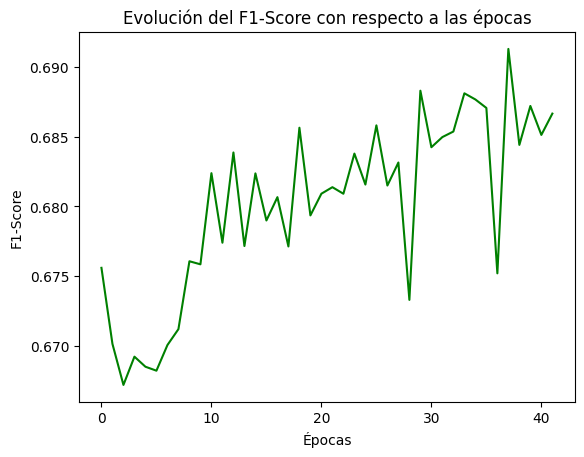

In [82]:
# Gráfico de f1-score con respecto a las épocas
plt.plot(np.arange(len(f1_score_ev_2)), f1_score_ev_2, color="green")
plt.title("Evolución del F1-Score con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("F1-Score")

Text(0, 0.5, 'Función de costos')

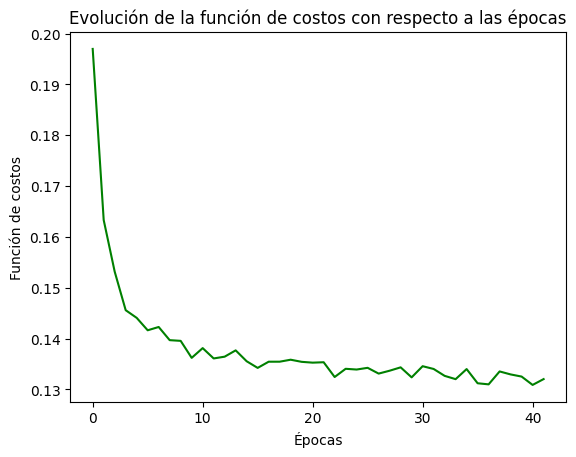

In [83]:
# Gráfico de la función de costos con respecto a las épocas
plt.plot(np.arange(len(f1_score_ev_2)), loss_ev_2, color="green")
plt.title("Evolución de la función de costos con respecto a las épocas")
plt.xlabel("Épocas")
plt.ylabel("Función de costos")

In [84]:
# Se evalúa el modelo en el set de testeo
results = model.evaluate(x=test_features, y=test_labels_enc)

703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8884 - f1_score: 0.7376 - fn: 8364.6162 - fp: 429.5781 - loss: 0.0866 - precision: 0.8662 - recall: 0.2587 - tn: 67249.8438 - tp: 2915.2869


In [85]:
# Se imprimen los resultados de esta evaluación
for (metric_name, value) in zip(metric_names, results):
  print(f"{metric_name}: {value}")

loss: 0.08541097491979599
tp: 5855.0
fp: 854.0
tn: 134014.0
fn: 16623.0
precision: 0.8727083206176758
accuracy: 0.8889262080192566
recall: 0.2604769170284271
f1_score: 0.7383584380149841


In [86]:
# Se hacen las predicciones usando los datos de testeo
pred = model.predict(test_features)
# Código para "retraer" el One-Hot encoding y volver al LabelEncoding
pred = np.argmax(pred, axis = 1)
test_labels = np.argmax(test_labels_enc, axis=1)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Text(0.5, 1.0, 'Matriz de confusión de la red neuronal')

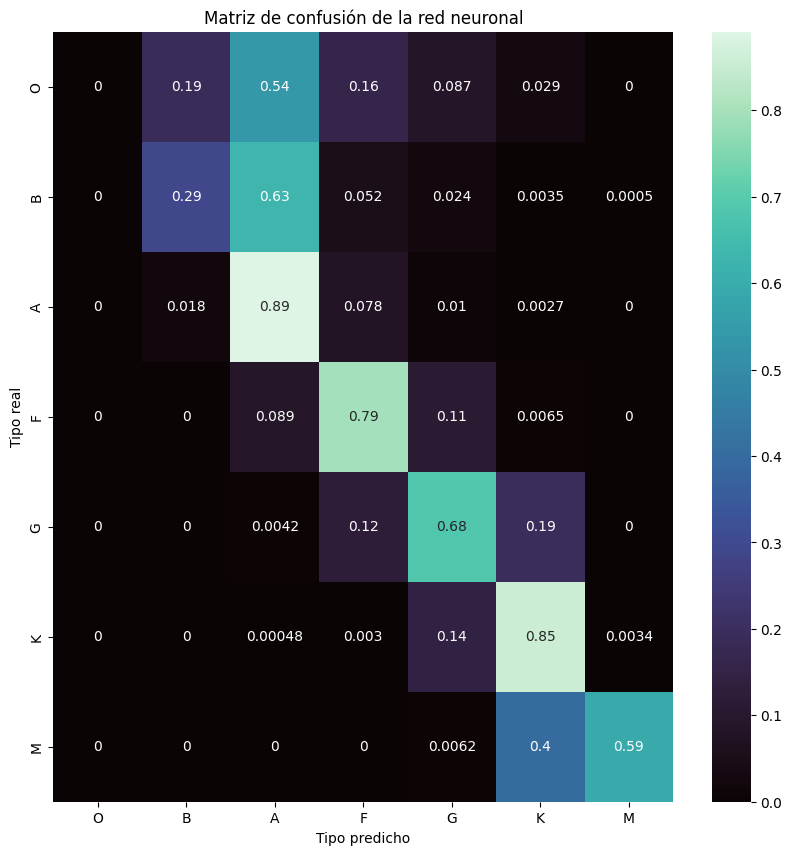

In [87]:
# Se crea la matriz de confusión usando el método confusion_matrix, específicando a que corresponde cada fila y columna
_, ax = plt.subplots(figsize=(10,10))
cm = pd.DataFrame(confusion_matrix(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), normalize='true', labels=tipos_espectrales), columns=tipos_espectrales, index=tipos_espectrales)
sns.heatmap(cm, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True))

ax.set_ylabel("Tipo real")
ax.set_xlabel("Tipo predicho")
ax.set_title("Matriz de confusión de la red neuronal")

In [88]:
# Reporte de clasificación
print(classification_report(encoder.inverse_transform(test_labels), encoder.inverse_transform(pred), zero_division=0))

              precision    recall  f1-score   support

           A       0.65      0.89      0.75      3737
           B       0.88      0.29      0.44      2013
           F       0.81      0.79      0.80      5081
           G       0.67      0.68      0.68      4532
           K       0.81      0.85      0.83      6244
           M       0.96      0.59      0.73       802
           O       0.00      0.00      0.00        69

    accuracy                           0.75     22478
   macro avg       0.68      0.59      0.60     22478
weighted avg       0.76      0.75      0.74     22478

